In [1]:
!pip install aif360

     |████████████████████████████████| 56.4MB 49.8MB/s 


In [2]:
!pip install BlackBoxAuditing

     |████████████████████████████████| 2.6MB 2.8MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=9da0d3a116042c596157d5357b86f71d2251c513edf8c5c99624e12c4035f920
  Stored in directory: /tmp/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
Successfully built BlackBoxAuditing


In [3]:
!pip install numpy --upgrade

Requirement already up-to-date: numpy in /opt/conda/lib/python3.6/site-packages (1.17.0)


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
from tqdm import tqdm
from IPython.display import Markdown, display


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

from aif360.datasets import BinaryLabelDataset, StandardDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve, classification_report 
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

['plain-model', 'hiring']


In [5]:
df = pd.read_csv('../input/hiring/hiring-dataset.csv')

In [6]:
map_dict = {'No': 0, 'Yes': 1}
df['Hired'] = df['Hired'].apply(lambda x: map_dict[str(x)])

map_dict = {'F': 0, 'M': 1, 'nan': 2}
df['Candidate Gender'] = df['Candidate Gender'].apply(lambda x: map_dict[str(x)])

In [7]:
data_with_scores = df.dropna(subset=["iq", "ambition", "interpersonal", "creativity", "fluid_iq", "achievement", 
                                                   "achievement_striving", "agreeableness", "benevolence", "cog_flex", 
                                                   "collectivism", "core_self_evaluation", "curiosity", "extraversion", 
                                                   "neuroticism", "openness", "self_discipline", "total score"])

protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Ethnicity Type', 'Candidate Is Internal', 'Candiate is disabled', 'Age (Years)', 
                   'Candidate Gender', 'Manager Gender', 'Recruiter Gender', 'Hired']

data_with_scores = data_with_scores[data_with_scores['Candidate Gender']!=2]


from sklearn.model_selection import StratifiedShuffleSplit

X = data_with_scores
y = data_with_scores['Hired']

Xtrain_, Xtest_, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 235)

Xtrain_['Hired'] = y_train
Xtest_['Hired'] = y_test
training_df = Xtrain_
test_df = Xtest_


# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train))
print(test_counts_label/ len(y_test))

Label Distributions: 

[0.98686758 0.01313242]
[0.98669434 0.01330566]


In [8]:
protected_class = ['Job Schedule', 'Job Type', 'Location', 'Job Field', 'Application Source Type', 
                   'Candidate Is Internal', 'Ethnicity Type', 'Candiate is disabled', 'Age (Years)',
                   'Manager Gender', 'Recruiter Gender']

train = training_df.drop(protected_class, axis=1)
test = test_df.drop(protected_class, axis=1)
train = train[train['Candidate Gender']!=2]
test = test[test['Candidate Gender']!=2]

privileged_sex = [1]
favorable_label = 1
unprivileged_groups = [{'Candidate Gender': 0}]
privileged_groups = [{'Candidate Gender': 1}]

original_training_dataset = StandardDataset(train, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Candidate Gender'], 
                               privileged_classes=[privileged_sex])
original_test_dataset = StandardDataset(test, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Candidate Gender'], 
                               privileged_classes=[privileged_sex])

In [9]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(original_training_dataset.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(original_training_dataset.favorable_label, original_training_dataset.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(original_training_dataset.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(original_training_dataset.privileged_protected_attributes, 
      original_training_dataset.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(original_training_dataset.feature_names)

#### Training Dataset shape

(19113, 19)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Candidate Gender']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['iq', 'ambition', 'interpersonal', 'creativity', 'fluid_iq', 'achievement', 'achievement_striving', 'agreeableness', 'benevolence', 'cog_flex', 'collectivism', 'core_self_evaluation', 'curiosity', 'extraversion', 'neuroticism', 'openness', 'self_discipline', 'total score', 'Candidate Gender']


In [10]:
index = original_training_dataset.feature_names.index('Candidate Gender')
X_train = np.delete(original_training_dataset.features, index, axis=1)
X_test = np.delete(original_test_dataset.features, index, axis=1)
y_train = original_training_dataset.labels.ravel()
y_test = original_test_dataset.labels.ravel()

In [11]:
plain_lr = joblib.load('../input/plain-model/plain_lr_model.pkl') 
y_pred_lr = plain_lr.predict(X_test)

plain_svc = joblib.load('../input/plain-model/plain_svc_model.pkl') 
y_pred_svc = plain_svc.predict(X_test)

In [12]:
y_pred_lr_df = test.copy()
y_pred_lr_df['Hired'] = y_pred_lr
y_pred_svc_df = test.copy()
y_pred_svc_df['Hired'] = y_pred_svc


plain_predictions_test_dataset_lr = StandardDataset(y_pred_lr_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])
plain_predictions_test_dataset_svc = StandardDataset(y_pred_svc_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])

In [13]:
def print_metrics(classified_metric, title):

    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    bal_acc = 0.5*(TPR+TNR)

    print(title)
    print("Test set: Classification accuracy = %f" % classified_metric.accuracy())
    print("Test set: Balanced classification accuracy = %f" % bal_acc)
    print("Test set: Statistical parity difference = %f" % classified_metric.statistical_parity_difference())
    print("Test set: Disparate impact = %f" % classified_metric.disparate_impact())
    print("Test set: Equal opportunity difference = %f" % classified_metric.equal_opportunity_difference())
    print("Test set: Average odds difference = %f" % classified_metric.average_odds_difference())
    print("Test set: Theil index = %f" % classified_metric.theil_index())
    print("Test set: False negative rate difference = %f" % classified_metric.false_positive_rate_difference())
    print()

In [14]:
def produce_metrics_dataframe(classifier, algorithm, classified_metric):
    
    TPR = classified_metric.true_positive_rate()
    TNR = classified_metric.true_negative_rate()
    FPR = classified_metric.false_positive_rate()
    bal_acc = 0.5*(TPR+TNR)
    roc_auc = auc([0, FPR, 1], [0, TPR, 1])
    
    results = {'Classifier': classifier,
            'Algorithm': algorithm,
            'Classification accuracy': classified_metric.accuracy(),
            'Balanced classification accuracy': bal_acc, 
            'Precision': classified_metric.precision(),
            'Recall': classified_metric.recall(),
            'F1 score': 2*classified_metric.precision()*classified_metric.recall()/(classified_metric.recall()+classified_metric.precision()),
            'AUC': roc_auc,
            'Statistical parity difference': classified_metric.statistical_parity_difference(),
            'Disparate impact': classified_metric.disparate_impact(),
            'Equal opportunity difference': classified_metric.equal_opportunity_difference(),
            'Average odds difference': classified_metric.average_odds_difference(),
            'False positive rate difference': classified_metric.false_positive_rate_difference()
            }
    return results

In [15]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'false_positive_rate_difference']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.false_positive_rate_difference()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.2]
    rect = [-0.1,-0.1,-0.1,0.8,-0.1]
    bottom = [-1,-1,-1,0,-1]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[-0.1,0.1]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:3].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:3], y=fair_metrics.iloc[1:3][cols[i]])

        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')
        
def get_fair_metrics_and_plot(data, pred, plot=True, model_aif=False):
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [16]:
classified_metric_nodebiasing_test_lr = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_lr,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")

classified_metric_nodebiasing_test_svc = ClassificationMetric(original_test_dataset,
                                         plain_predictions_test_dataset_svc,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.564575
Test set: Balanced classification accuracy = 0.539511
Test set: Statistical parity difference = -0.028409
Test set: Disparate impact = 0.936281
Test set: Equal opportunity difference = -0.140217
Test set: Average odds difference = -0.083578
Test set: Theil index = 0.065636
Test set: False negative rate difference = -0.026938

Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.508057
Test set: Balanced classification accuracy = 0.528972
Test set: Statistical parity difference = -0.019760
Test set: Disparate impact = 0.960503
Test set: Equal opportunity difference = -0.119203
Test set: Average odds difference = -0.068822
Test set: Theil index = 0.063171
Test set: False negative rate difference = -0.018441



In [17]:
results_lr = produce_metrics_dataframe('LR', '/', classified_metric_nodebiasing_test_lr)
results_svc = produce_metrics_dataframe('SVM', '/', classified_metric_nodebiasing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df_lr, results_df_svc],ignore_index = True)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Candidate Gender attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Candidate Gender,-0.028409,-0.140217,0.083578,0.936281,-0.026938


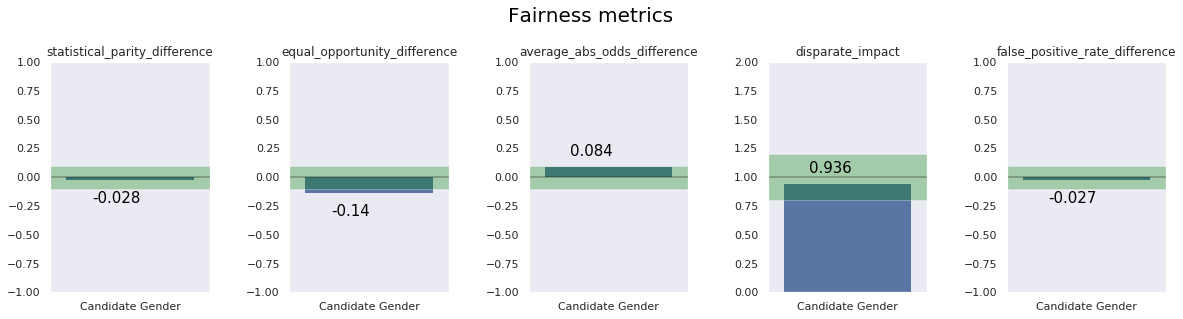

In [18]:
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset, y_pred_lr)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Candidate Gender attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.00000,0.000000,0.000000,1.000000,0.000000
Candidate Gender,-0.01976,-0.119203,0.068822,0.960503,-0.018441


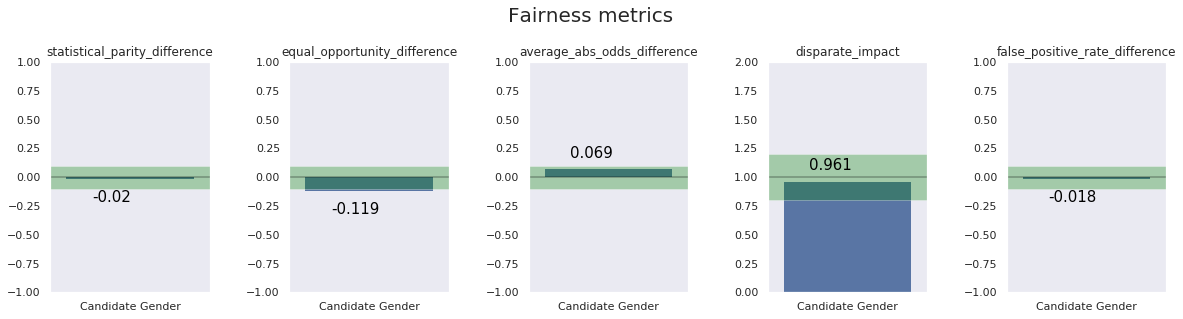

In [19]:
display(Markdown('### Bias metrics'))
fair = get_fair_metrics_and_plot(original_test_dataset, y_pred_svc)

# Reweighing

In [20]:
from aif360.algorithms.preprocessing import Reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_training_dataset)
transf_training_dataset = RW.transform(original_training_dataset)

In [21]:
metric_orig_train = BinaryLabelDatasetMetric(original_training_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_training_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
print("Transformed training dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

Original training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.003375
Transformed training dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000000


In [22]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
print("Transformed testing dataset:")
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

Original testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = 0.000747
Transformed testing dataset:
Difference in mean outcomes between privileged and unprivileged groups = -0.002535


In [23]:
new_weights = pd.DataFrame({'Candidate Gender': train['Candidate Gender'],
              'Hired': train['Hired'],
              'Original_weight': np.ones(shape=(train.shape[0],)),
              'new_weight': transf_training_dataset.instance_weights})
new_weights.reset_index()
new_weights_00 = new_weights[(new_weights['Candidate Gender']==0)&(new_weights['Hired']==0)]
new_weights_01 = new_weights[(new_weights['Candidate Gender']==0)&(new_weights['Hired']==1)]
new_weights_10 = new_weights[(new_weights['Candidate Gender']==1)&(new_weights['Hired']==0)]
new_weights_11 = new_weights[(new_weights['Candidate Gender']==1)&(new_weights['Hired']==1)]
print(new_weights_00['new_weight'].iloc[0])
print(new_weights_01['new_weight'].iloc[0])
print(new_weights_10['new_weight'].iloc[0])
print(new_weights_11['new_weight'].iloc[0])
# new_weights.iloc[[1, 2, 3, 4], :]

1.0021835306532874
0.859306468283466
0.9987605124366729
1.10285182318588


In [24]:
unbiased_lr = LogisticRegression(penalty='l2', C=1, class_weight={0:1,1:75})
unbiased_lr.fit(X_train, y_train, sample_weight=transf_training_dataset.instance_weights)
    
y_pred_transf_lr = unbiased_lr.predict(X_test)

In [25]:
unbiased_svc =  SVC(kernel = 'linear', C=1, class_weight={0:1,1:75})
unbiased_svc.fit(X_train, y_train, sample_weight=transf_training_dataset.instance_weights)
    
y_pred_transf_svc = unbiased_svc.predict(X_test)

In [26]:
y_pred_transf_lr_df = test.copy()
y_pred_transf_lr_df['Hired'] = y_pred_transf_lr
y_pred_transf_svc_df = test.copy()
y_pred_transf_svc_df['Hired'] = y_pred_transf_svc


transf_predictions_test_dataset_lr = StandardDataset(y_pred_transf_lr_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])
transf_predictions_test_dataset_svc = StandardDataset(y_pred_transf_svc_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])

classified_metric_reweighing_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_reweighing_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)



In [27]:
results_lr = produce_metrics_dataframe('LR', 'Reweighing', classified_metric_reweighing_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Reweighing', classified_metric_reweighing_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [28]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Precision,Recall,F1 score,AUC,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,False positive rate difference
0,LR,/,0.564575,0.539511,0.015686,0.513761,0.030443,0.539511,-0.028409,0.936281,-0.140217,-0.083578,-0.026938
1,SVM,/,0.508057,0.528972,0.014848,0.550459,0.028916,0.528972,-0.019760,0.960503,-0.119203,-0.068822,-0.018441
2,LR,Reweighing,0.563965,0.530151,0.015122,0.495413,0.029348,0.530151,-0.026997,0.939397,-0.071739,-0.049085,-0.026430
3,SVM,Reweighing,0.514038,0.527478,0.014787,0.541284,0.028788,0.527478,-0.021862,0.955816,-0.144203,-0.082215,-0.020228


In [29]:
def fair_metrics(dataset, pred, dataset2, pred2, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
        dataset_pred2 = pred2
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
        dataset_pred2 = dataset2.copy()
        dataset_pred2.labels = pred2
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'false_positive_rate_difference']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.false_positive_rate_difference()]],
                           columns  = cols,
                           index = ['before']
                          )
        fair_metrics = fair_metrics.append(row)

    for attr in dataset_pred2.protected_attribute_names:
        idx = dataset_pred2.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred2.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred2.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset2, 
                                                     dataset_pred2,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred2,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.false_positive_rate_difference()]],
                           columns  = cols,
                           index = ['after']
                          )
        fair_metrics = fair_metrics.append(row)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.2]
    rect = [-0.1,-0.1,-0.1,0.8,-0.1]
    bottom = [-1,-1,-1,0,-1]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[-0.1,0.1]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:3].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))


    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:3], y=fair_metrics.iloc[1:3][cols[i]])
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')
        
def get_fair_metrics_and_plot(data, pred, data2, pred2, plot=True, model_aif=False):
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred, data2, pred2)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.028409,-0.140217,0.083578,0.936281,-0.026938
after,-0.026997,-0.071739,0.049085,0.939397,-0.026430


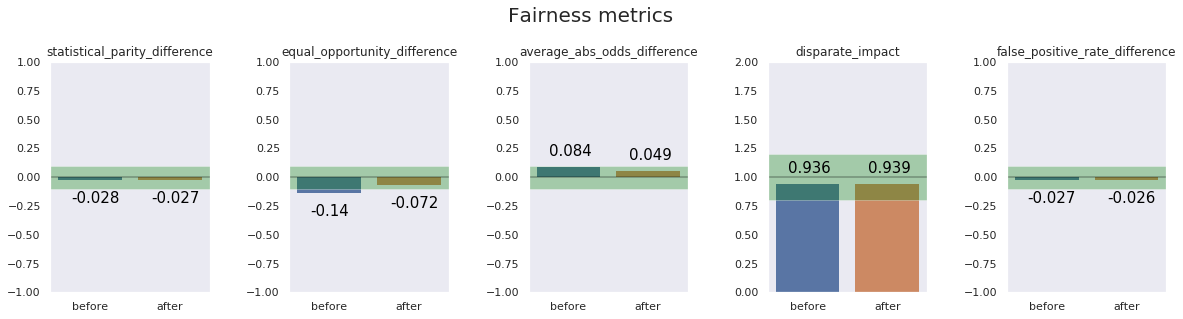

In [30]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_lr, original_test_dataset, y_pred_transf_lr)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.019760,-0.119203,0.068822,0.960503,-0.018441
after,-0.021862,-0.144203,0.082215,0.955816,-0.020228


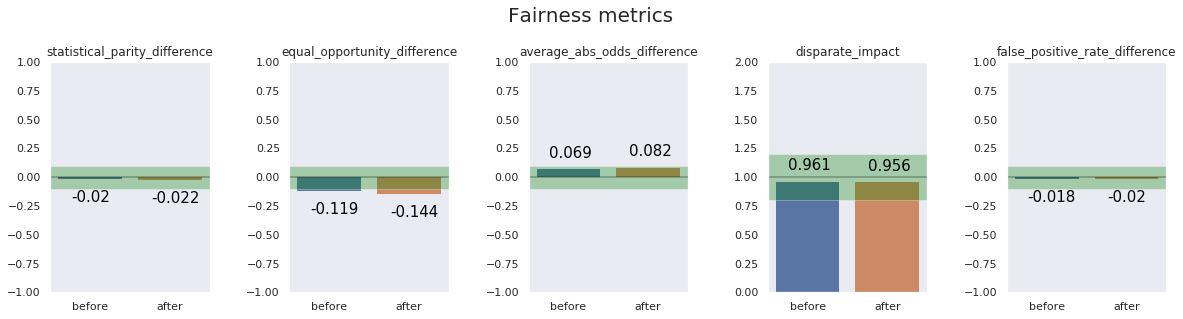

In [31]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_svc, original_test_dataset, y_pred_transf_svc)

# Disparate Impact Remover

In [32]:
from aif360.algorithms.preprocessing import DisparateImpactRemover

index = original_training_dataset.feature_names.index('Candidate Gender')

DI = []
bal_acc = []
for level in tqdm(np.linspace(0., 1., 11)):
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(original_training_dataset)
    test_repd = di.fit_transform(original_test_dataset)
    
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)
    y_tr = train_repd.labels.ravel()
    
    lmod = LogisticRegression(penalty='l2', C=1, class_weight={0:1,1:75})
    lmod.fit(X_tr, y_tr)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = lmod.predict(X_te)

    cm = ClassificationMetric(test_repd,
                             test_repd_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
    DI.append(cm.disparate_impact())
    TPR = cm.true_positive_rate()
    TNR = cm.true_negative_rate()
    acc = 0.5*(TPR+TNR)
    bal_acc.append(acc)

100%|██████████| 11/11 [01:39<00:00,  8.93s/it]


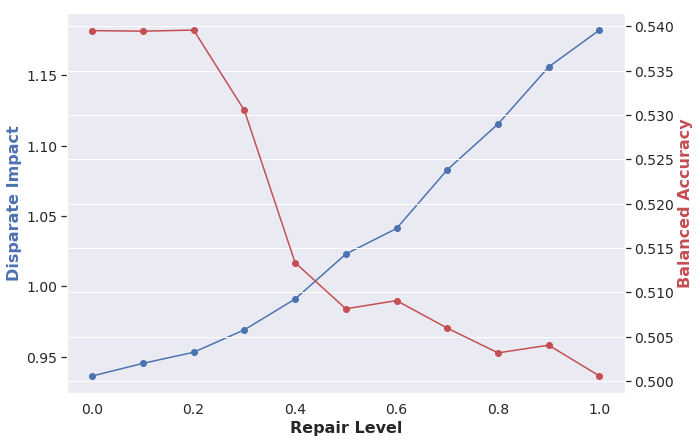

In [33]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(np.linspace(0, 1, 11), DI, marker='o')
ax1.set_xlabel('Repair Level', fontsize=16, fontweight='bold')
ax1.set_ylabel('Disparate Impact', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(np.linspace(0, 1, 11), bal_acc, marker='o', color='r')
ax2.set_ylabel('Balanced Accuracy', color='r', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [34]:
DIR = DisparateImpactRemover(repair_level=0.4)
transf_training_dataset = DIR.fit_transform(original_training_dataset)
transf_test_dataset = DIR.fit_transform(original_test_dataset)

In [35]:
train.columns.values.tolist()
train_dir = pd.DataFrame(np.hstack([transf_training_dataset.features, transf_training_dataset.labels]),columns=train.columns.values.tolist())
gender_0_orig = train.loc[train['Candidate Gender'] == 0]
gender_0_transf = train_dir.loc[train_dir['Candidate Gender'] == 0]
gender_0_orig.sort_values('iq')[:5]

,iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Hired
14056,-2.523867,-0.058443,1.162129,1.565253,-2.566492,0.157705,-0.022463,0.220669,-0.023060,0.593768,0.027558,0.035711,0.708425,0.187241,-1.586673,0.690745,-0.075060,24.0,0,0
28841,-2.461585,2.536760,1.949881,1.574910,-2.503158,0.524222,0.793407,0.374383,0.470029,0.502494,-0.017363,1.085790,0.742682,0.974141,-1.419788,0.755005,0.940248,85.0,0,0
19347,-2.410946,-0.893404,2.104757,1.572786,-2.451664,0.378321,-0.109868,0.589963,0.597826,0.596006,0.253685,-0.520146,0.805739,0.983120,-1.243320,0.607306,-0.366640,12.0,0,0
77486,-2.391987,0.684919,1.787170,1.326463,-2.432384,-0.017236,0.287508,0.823593,0.617694,0.592343,0.055885,0.226416,0.556964,0.587630,-1.255598,0.543268,0.245338,1.0,0,0
9913,-2.383519,1.663584,0.859122,1.411257,-2.423774,0.402582,0.478741,-0.441921,0.107710,0.580242,-0.155167,0.838280,0.778228,1.284102,-0.521417,0.451531,0.537771,1.0,0,0


In [36]:
gender_0_transf.sort_values('iq')[:5]

,iq,ambition,interpersonal,creativity,fluid_iq,achievement,achievement_striving,agreeableness,benevolence,cog_flex,collectivism,core_self_evaluation,curiosity,extraversion,neuroticism,openness,self_discipline,total score,Candidate Gender,Hired
372,-2.523867,-0.058443,1.154927,1.561969,-2.566492,0.157705,-0.031082,0.199940,-0.039433,0.591613,0.024074,0.034905,0.708275,0.165877,-1.604683,0.687300,-0.083844,24.0,0.0,0.0
2766,-2.461585,2.486993,1.949881,1.571687,-2.503158,0.524222,0.788076,0.360127,0.462550,0.499700,-0.020698,1.085790,0.742327,0.974141,-1.440834,0.753457,0.936490,85.0,0.0,0.0
2032,-2.410946,-0.893404,2.104757,1.569301,-2.451664,0.378321,-0.116970,0.577873,0.595233,0.594151,0.252994,-0.520146,0.805680,0.983120,-1.266032,0.601733,-0.377565,12.0,0.0,0.0
5023,-2.391987,0.677967,1.787170,1.321146,-2.432384,-0.017236,0.276703,0.814225,0.616652,0.590250,0.053907,0.225199,0.556964,0.585118,-1.280377,0.537862,0.239271,1.0,0.0,0.0
3955,-2.383519,1.656289,0.837472,1.406047,-2.423774,0.402582,0.468524,-0.467737,0.092690,0.578195,-0.157417,0.838280,0.777810,1.284102,-0.529267,0.444419,0.535129,1.0,0.0,0.0


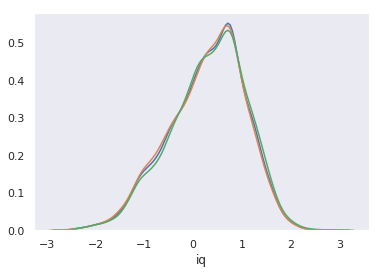

In [37]:
gender_1_orig = train.loc[train['Candidate Gender'] == 1]
sns.distplot(train_dir['iq'], hist=False)
sns.distplot(gender_0_orig['iq'], hist=False)
sns.distplot(gender_1_orig['iq'], hist=False)

In [38]:
index = transf_training_dataset.feature_names.index('Candidate Gender')
X_tr = np.delete(transf_training_dataset.features, index, axis=1)
X_te = np.delete(transf_test_dataset.features, index, axis=1)
y_tr = transf_training_dataset.labels.ravel()

unbiased_lr = LogisticRegression(penalty='l2', C=1, class_weight={0:1,1:75})
unbiased_lr.fit(X_tr, y_tr)

y_pred_transf_lr = unbiased_lr.predict(X_te)
y_pred_transf_lr_df = test.copy()
y_pred_transf_lr_df['Hired'] = y_pred_transf_lr


transf_predictions_test_dataset_lr = StandardDataset(y_pred_transf_lr_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])

classified_metric_dir_test_lr = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [39]:
unbiased_svc = SVC(kernel='linear', C=1, class_weight={0:1,1:75})
unbiased_svc.fit(X_tr, y_tr)
    
y_pred_transf_svc = unbiased_svc.predict(X_te)
y_pred_transf_svc_df = test.copy()
y_pred_transf_svc_df['Hired'] = y_pred_transf_svc

transf_predictions_test_dataset_svc = StandardDataset(y_pred_transf_svc_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])

classified_metric_dir_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [40]:
y_pred_transf_svc_df = test.copy()
y_pred_transf_svc_df['Hired'] = y_pred_transf_svc

transf_predictions_test_dataset_svc = StandardDataset(y_pred_transf_svc_df, 
                                                   label_name='Hired', 
                                                   favorable_classes=[favorable_label], 
                                                   protected_attribute_names=['Candidate Gender'], 
                                                   privileged_classes=[privileged_sex])

classified_metric_dir_test_svc = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [41]:
results_lr = produce_metrics_dataframe('LR', 'Disparate Impact Remover', classified_metric_dir_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Disparate Impact Remover', classified_metric_dir_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [42]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Precision,Recall,F1 score,AUC,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,False positive rate difference
0,LR,/,0.564575,0.539511,0.015686,0.513761,0.030443,0.539511,-0.028409,0.936281,-0.140217,-0.083578,-0.026938
1,SVM,/,0.508057,0.528972,0.014848,0.550459,0.028916,0.528972,-0.019760,0.960503,-0.119203,-0.068822,-0.018441
2,LR,Reweighing,0.563965,0.530151,0.015122,0.495413,0.029348,0.530151,-0.026997,0.939397,-0.071739,-0.049085,-0.026430
3,SVM,Reweighing,0.514038,0.527478,0.014787,0.541284,0.028788,0.527478,-0.021862,0.955816,-0.144203,-0.082215,-0.020228
4,LR,Disparate Impact Remover,0.566528,0.513349,0.014116,0.458716,0.027390,0.513349,-0.003904,0.991000,-0.013768,-0.008778,-0.003789
5,SVM,Disparate Impact Remover,0.504028,0.522405,0.014489,0.541284,0.028223,0.522405,0.007471,1.015111,-0.183696,-0.086820,0.010056


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.028409,-0.140217,0.083578,0.936281,-0.026938
after,-0.003904,-0.013768,0.008778,0.991000,-0.003789


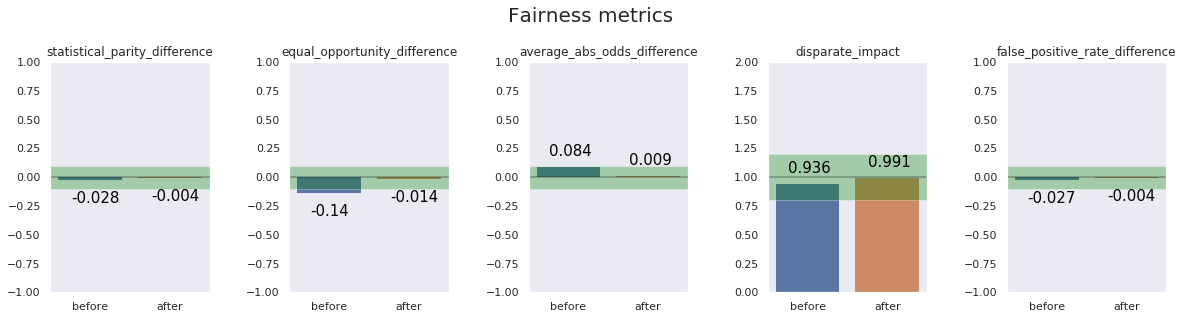

In [43]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_lr, original_test_dataset, y_pred_transf_lr)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.019760,-0.119203,0.068822,0.960503,-0.018441
after,0.007471,-0.183696,0.096876,1.015111,0.010056


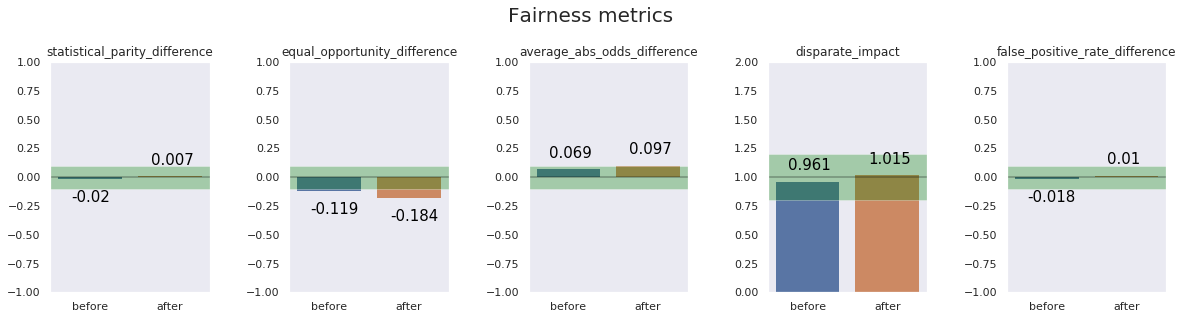

In [44]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_svc, original_test_dataset, y_pred_transf_svc)

# Adversarial Debiasing

In [45]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(original_training_dataset.features, original_training_dataset.labels.ravel())
train_ros = pd.DataFrame(X_ros, columns = ['iq', 'ambition', 'interpersonal', 'creativity', 'fluid_iq', 'achievement', 'achievement_striving', 'agreeableness', 'benevolence', 'cog_flex', 'collectivism', 'core_self_evaluation', 'curiosity', 'extraversion', 'neuroticism', 'openness', 'self_discipline', 'total score', 'Candidate Gender'])
train_ros['Hired'] = y_ros

ros_training_dataset = StandardDataset(train_ros, 
                               label_name='Hired', 
                               favorable_classes=[favorable_label], 
                               protected_attribute_names=['Candidate Gender'], 
                               privileged_classes=[privileged_sex])

Using TensorFlow backend.


In [46]:
from aif360.algorithms.inprocessing import AdversarialDebiasing

tf.reset_default_graph()
sess = tf.Session()

AD = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                          privileged_groups=privileged_groups,
                          scope_name="debiased_classifier", 
                          debias=True, sess=sess) 
AD.fit(ros_training_dataset)
y_pred_AD = AD.predict(original_test_dataset)

epoch 0; iter: 0; batch classifier loss: 2.606324; batch adversarial loss: 0.731426
epoch 0; iter: 200; batch classifier loss: 0.727587; batch adversarial loss: 0.704163
epoch 1; iter: 0; batch classifier loss: 0.725492; batch adversarial loss: 0.702076
epoch 1; iter: 200; batch classifier loss: 0.696812; batch adversarial loss: 0.695940
epoch 2; iter: 0; batch classifier loss: 0.662290; batch adversarial loss: 0.698187
epoch 2; iter: 200; batch classifier loss: 0.665624; batch adversarial loss: 0.677557
epoch 3; iter: 0; batch classifier loss: 0.653337; batch adversarial loss: 0.664070
epoch 3; iter: 200; batch classifier loss: 0.613410; batch adversarial loss: 0.660962
epoch 4; iter: 0; batch classifier loss: 0.687598; batch adversarial loss: 0.648033
epoch 4; iter: 200; batch classifier loss: 0.629645; batch adversarial loss: 0.674261
epoch 5; iter: 0; batch classifier loss: 0.620798; batch adversarial loss: 0.683532
epoch 5; iter: 200; batch classifier loss: 0.646897; batch adversa

In [47]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False, sess=sess)
plain_model.fit(ros_training_dataset)
y_pred_plain = plain_model.predict(original_test_dataset)

epoch 0; iter: 0; batch classifier loss: 1.095663
epoch 0; iter: 200; batch classifier loss: 0.819639
epoch 1; iter: 0; batch classifier loss: 0.692377
epoch 1; iter: 200; batch classifier loss: 0.692611
epoch 2; iter: 0; batch classifier loss: 0.631661
epoch 2; iter: 200; batch classifier loss: 0.682273
epoch 3; iter: 0; batch classifier loss: 0.632916
epoch 3; iter: 200; batch classifier loss: 0.620544
epoch 4; iter: 0; batch classifier loss: 0.626666
epoch 4; iter: 200; batch classifier loss: 0.616850
epoch 5; iter: 0; batch classifier loss: 0.587630
epoch 5; iter: 200; batch classifier loss: 0.650993
epoch 6; iter: 0; batch classifier loss: 0.599507
epoch 6; iter: 200; batch classifier loss: 0.540146
epoch 7; iter: 0; batch classifier loss: 0.595495
epoch 7; iter: 200; batch classifier loss: 0.609529
epoch 8; iter: 0; batch classifier loss: 0.550247
epoch 8; iter: 200; batch classifier loss: 0.591443
epoch 9; iter: 0; batch classifier loss: 0.609168
epoch 9; iter: 200; batch classi

In [48]:
classified_metric_noadversarialdebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 y_pred_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_adversarialdebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 y_pred_AD,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print_metrics(classified_metric_noadversarialdebiasing_test, "Plain model - without debiasing - classification metrics")
print_metrics(classified_metric_adversarialdebiasing_test, "model - with adversarial debiasing - classification metrics")

Plain model - without debiasing - classification metrics
Test set: Classification accuracy = 0.692871
Test set: Balanced classification accuracy = 0.527594
Test set: Statistical parity difference = 0.026684
Test set: Disparate impact = 1.090794
Test set: Equal opportunity difference = 0.066667
Test set: Average odds difference = 0.046381
Test set: Theil index = 0.066190
Test set: False negative rate difference = 0.026095

model - with adversarial debiasing - classification metrics
Test set: Classification accuracy = 0.683838
Test set: Balanced classification accuracy = 0.541118
Test set: Statistical parity difference = 0.019725
Test set: Disparate impact = 1.064384
Test set: Equal opportunity difference = -0.030797
Test set: Average odds difference = -0.005221
Test set: Theil index = 0.066143
Test set: False negative rate difference = 0.020355



In [49]:
results_plain = produce_metrics_dataframe('/', 'no Adversarial Debiasing', classified_metric_noadversarialdebiasing_test)
results_ad = produce_metrics_dataframe('/', 'Adversarial Debiasing', classified_metric_adversarialdebiasing_test)
results_df_plain = pd.DataFrame(results_plain, index = [0])
results_df_ad = pd.DataFrame(results_ad, index = [0])
results_df = pd.concat([results_df, results_df_plain, results_df_ad],ignore_index = True)

In [50]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Precision,Recall,F1 score,AUC,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,False positive rate difference
0,LR,/,0.564575,0.539511,0.015686,0.513761,0.030443,0.539511,-0.028409,0.936281,-0.140217,-0.083578,-0.026938
1,SVM,/,0.508057,0.528972,0.014848,0.550459,0.028916,0.528972,-0.019760,0.960503,-0.119203,-0.068822,-0.018441
2,LR,Reweighing,0.563965,0.530151,0.015122,0.495413,0.029348,0.530151,-0.026997,0.939397,-0.071739,-0.049085,-0.026430
3,SVM,Reweighing,0.514038,0.527478,0.014787,0.541284,0.028788,0.527478,-0.021862,0.955816,-0.144203,-0.082215,-0.020228
4,LR,Disparate Impact Remover,0.566528,0.513349,0.014116,0.458716,0.027390,0.513349,-0.003904,0.991000,-0.013768,-0.008778,-0.003789
5,SVM,Disparate Impact Remover,0.504028,0.522405,0.014489,0.541284,0.028223,0.522405,0.007471,1.015111,-0.183696,-0.086820,0.010056
6,/,no Adversarial Debiasing,0.692871,0.527594,0.015694,0.357798,0.030069,0.527594,0.026684,1.090794,0.066667,0.046381,0.026095
7,/,Adversarial Debiasing,0.683838,0.541118,0.016751,0.394495,0.032138,0.541118,0.019725,1.064384,-0.030797,-0.005221,0.020355


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,0.026684,0.066667,0.046381,1.090794,0.026095
after,0.019725,-0.030797,0.025576,1.064384,0.020355


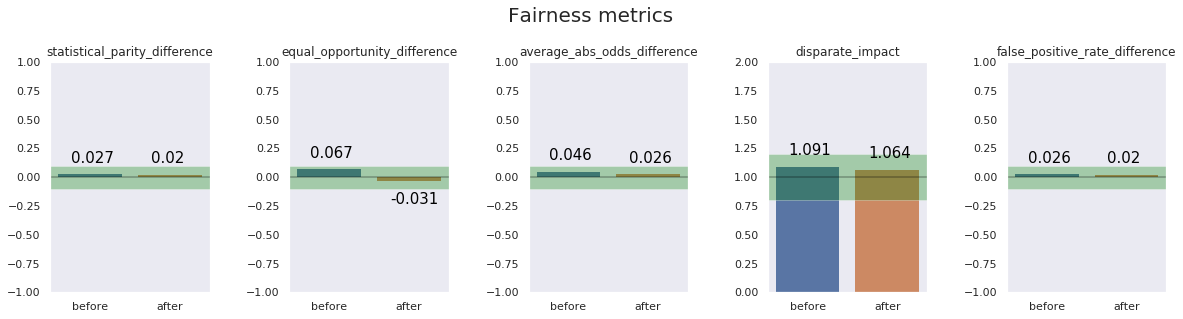

In [51]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_plain.labels, original_test_dataset, y_pred_AD.labels)

# Equality of Odds

In [52]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing


pos_ind = np.where(plain_lr.classes_ == original_test_dataset.favorable_label)[0][0]
dataset_orig_test_pred_lr = original_test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_lr.scores = plain_lr.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
dataset_orig_test_pred_lr.labels = y_pred_lr.reshape(-1,1)

pos_ind = np.where(plain_svc.classes_ == original_training_dataset.favorable_label)[0][0]
dataset_orig_test_pred_svc = original_test_dataset.copy(deepcopy=True)
dataset_orig_test_pred_svc.scores = plain_svc.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
dataset_orig_test_pred_svc.labels = y_pred_svc.reshape(-1,1)



EOP_lr = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
EOP_lr.fit(original_test_dataset, dataset_orig_test_pred_lr)
dataset_EOP_test_pred_lr = EOP_lr.predict(dataset_orig_test_pred_lr)

EOP_svc = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
EOP_svc.fit(original_test_dataset, dataset_orig_test_pred_svc)
dataset_EOP_test_pred_svc = EOP_svc.predict(dataset_orig_test_pred_svc)

In [53]:
print(dataset_orig_test_pred_lr.scores)
print('')
print(dataset_EOP_test_pred_lr.labels)

[[0.36194615]
 [0.4768236 ]
 [0.57198896]
 ...
 [0.63961716]
 [0.46291835]
 [0.60481747]]

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [54]:
classified_metric_eqodds_test_lr = ClassificationMetric(original_test_dataset,
                                                 dataset_EOP_test_pred_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_eqodds_test_svc = ClassificationMetric(original_test_dataset, 
                                                 dataset_EOP_test_pred_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)


print_metrics(classified_metric_eqodds_test_lr, "LR model - with Equalized Odds - classification metrics")
print_metrics(classified_metric_eqodds_test_svc, "SVM model - with Equalized Odds - classification metrics")

LR model - with Equalized Odds - classification metrics
Test set: Classification accuracy = 0.986572
Test set: Balanced classification accuracy = 0.499938
Test set: Statistical parity difference = 0.000345
Test set: Disparate impact = inf
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = 0.000175
Test set: Theil index = 0.013443
Test set: False negative rate difference = 0.000350

SVM model - with Equalized Odds - classification metrics
Test set: Classification accuracy = 0.986572
Test set: Balanced classification accuracy = 0.499938
Test set: Statistical parity difference = -0.000189
Test set: Disparate impact = 0.000000
Test set: Equal opportunity difference = 0.000000
Test set: Average odds difference = -0.000096
Test set: Theil index = 0.013443
Test set: False negative rate difference = -0.000191



In [55]:
results_lr = produce_metrics_dataframe('LR', 'Equalized Odds', classified_metric_eqodds_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Equalized Odds', classified_metric_eqodds_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [56]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Precision,Recall,F1 score,AUC,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,False positive rate difference
0,LR,/,0.564575,0.539511,0.015686,0.513761,0.030443,0.539511,-0.028409,0.936281,-0.140217,-0.083578,-0.026938
1,SVM,/,0.508057,0.528972,0.014848,0.550459,0.028916,0.528972,-0.019760,0.960503,-0.119203,-0.068822,-0.018441
2,LR,Reweighing,0.563965,0.530151,0.015122,0.495413,0.029348,0.530151,-0.026997,0.939397,-0.071739,-0.049085,-0.026430
3,SVM,Reweighing,0.514038,0.527478,0.014787,0.541284,0.028788,0.527478,-0.021862,0.955816,-0.144203,-0.082215,-0.020228
4,LR,Disparate Impact Remover,0.566528,0.513349,0.014116,0.458716,0.027390,0.513349,-0.003904,0.991000,-0.013768,-0.008778,-0.003789
5,SVM,Disparate Impact Remover,0.504028,0.522405,0.014489,0.541284,0.028223,0.522405,0.007471,1.015111,-0.183696,-0.086820,0.010056
6,/,no Adversarial Debiasing,0.692871,0.527594,0.015694,0.357798,0.030069,0.527594,0.026684,1.090794,0.066667,0.046381,0.026095
7,/,Adversarial Debiasing,0.683838,0.541118,0.016751,0.394495,0.032138,0.541118,0.019725,1.064384,-0.030797,-0.005221,0.020355
8,LR,Equalized Odds,0.986572,0.499938,0.000000,0.000000,NaN,0.499938,0.000345,inf,0.000000,0.000175,0.000350
9,SVM,Equalized Odds,0.986572,0.499938,0.000000,0.000000,NaN,0.499938,-0.000189,0.000000,0.000000,-0.000096,-0.000191


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.028409,-0.140217,0.083578,0.936281,-0.026938
after,0.000345,0.000000,0.000175,inf,0.000350


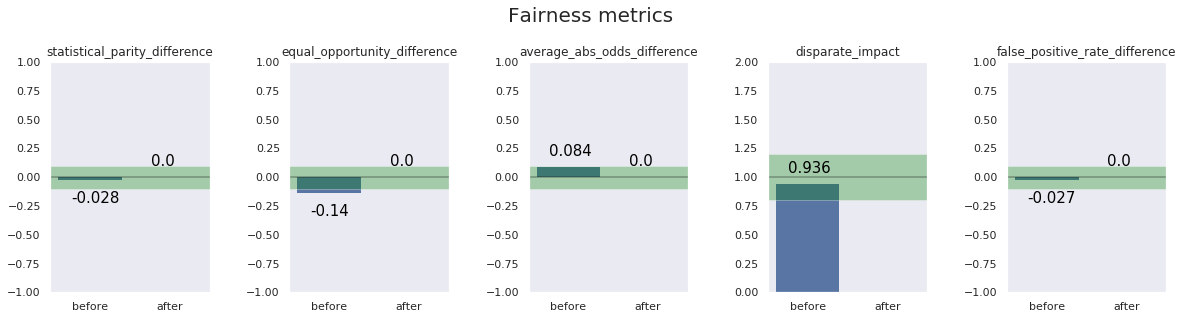

In [57]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_lr, original_test_dataset, dataset_EOP_test_pred_lr.labels)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.019760,-0.119203,0.068822,0.960503,-0.018441
after,-0.000189,0.000000,0.000096,0.000000,-0.000191


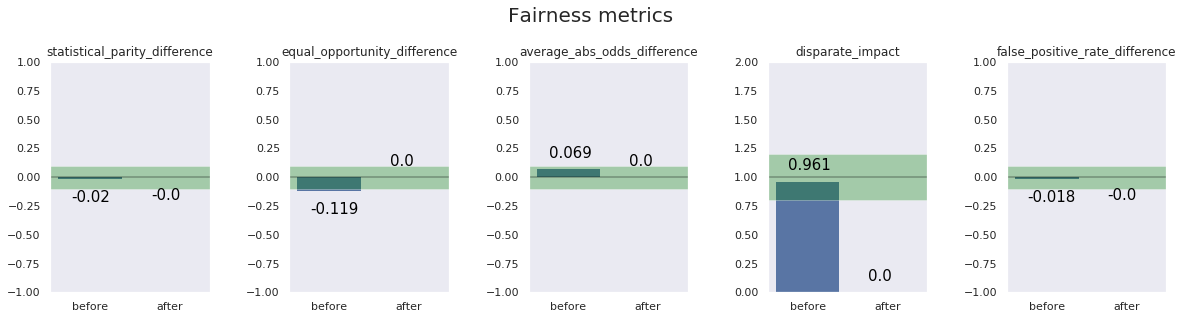

In [58]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_svc, original_test_dataset, dataset_EOP_test_pred_svc.labels)

# Reject Option Classification

In [59]:
from aif360.algorithms.postprocessing import RejectOptionClassification

ROC_lr = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
ROC_lr.fit(original_test_dataset, dataset_orig_test_pred_lr)
dataset_ROC_test_pred_lr = ROC_lr.predict(dataset_orig_test_pred_lr)

ROC_svc = RejectOptionClassification(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
ROC_svc.fit(original_test_dataset, dataset_orig_test_pred_svc)
dataset_ROC_test_pred_svc = ROC_svc.predict(dataset_orig_test_pred_svc)

In [60]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC_svc.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC_svc.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.0100
Optimal ROC margin = 0.0002


In [61]:
classified_metric_roc_test_lr = ClassificationMetric(original_test_dataset, 
                                                 dataset_ROC_test_pred_lr,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
classified_metric_roc_test_svc = ClassificationMetric(original_test_dataset, 
                                                 dataset_ROC_test_pred_svc,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

print_metrics(classified_metric_nodebiasing_test_lr, "Plain LR model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_roc_test_lr, "LR model - with Reject Option Classification - classification metrics")
print('')
print_metrics(classified_metric_nodebiasing_test_svc, "Plain SVM model - without debiasing - classification metrics")
print('')
print_metrics(classified_metric_roc_test_svc, "SVM model - with Reject Option Classification - classification metrics")

Plain LR model - without debiasing - classification metrics
Test set: Classification accuracy = 0.564575
Test set: Balanced classification accuracy = 0.539511
Test set: Statistical parity difference = -0.028409
Test set: Disparate impact = 0.936281
Test set: Equal opportunity difference = -0.140217
Test set: Average odds difference = -0.083578
Test set: Theil index = 0.065636
Test set: False negative rate difference = -0.026938


LR model - with Reject Option Classification - classification metrics
Test set: Classification accuracy = 0.421021
Test set: Balanced classification accuracy = 0.548221
Test set: Statistical parity difference = 0.043001
Test set: Disparate impact = 1.075637
Test set: Equal opportunity difference = -0.045652
Test set: Average odds difference = -0.000755
Test set: Theil index = 0.055968
Test set: False negative rate difference = 0.044143


Plain SVM model - without debiasing - classification metrics
Test set: Classification accuracy = 0.508057
Test set: Balanced

In [62]:
results_lr = produce_metrics_dataframe('LR', 'Reject Option Classification', classified_metric_roc_test_lr)
results_svc = produce_metrics_dataframe('SVM', 'Reject Option Classification', classified_metric_roc_test_svc)
results_df_lr = pd.DataFrame(results_lr, index = [0])
results_df_svc = pd.DataFrame(results_svc, index = [0])
results_df = pd.concat([results_df, results_df_lr, results_df_svc],ignore_index = True)

In [63]:
results_df

,Classifier,Algorithm,Classification accuracy,Balanced classification accuracy,Precision,Recall,F1 score,AUC,Statistical parity difference,Disparate impact,Equal opportunity difference,Average odds difference,False positive rate difference
0,LR,/,0.564575,0.539511,0.015686,0.513761,0.030443,0.539511,-0.028409,0.936281,-0.140217,-0.083578,-0.026938
1,SVM,/,0.508057,0.528972,0.014848,0.550459,0.028916,0.528972,-0.019760,0.960503,-0.119203,-0.068822,-0.018441
2,LR,Reweighing,0.563965,0.530151,0.015122,0.495413,0.029348,0.530151,-0.026997,0.939397,-0.071739,-0.049085,-0.026430
3,SVM,Reweighing,0.514038,0.527478,0.014787,0.541284,0.028788,0.527478,-0.021862,0.955816,-0.144203,-0.082215,-0.020228
4,LR,Disparate Impact Remover,0.566528,0.513349,0.014116,0.458716,0.027390,0.513349,-0.003904,0.991000,-0.013768,-0.008778,-0.003789
5,SVM,Disparate Impact Remover,0.504028,0.522405,0.014489,0.541284,0.028223,0.522405,0.007471,1.015111,-0.183696,-0.086820,0.010056
6,/,no Adversarial Debiasing,0.692871,0.527594,0.015694,0.357798,0.030069,0.527594,0.026684,1.090794,0.066667,0.046381,0.026095
7,/,Adversarial Debiasing,0.683838,0.541118,0.016751,0.394495,0.032138,0.541118,0.019725,1.064384,-0.030797,-0.005221,0.020355
8,LR,Equalized Odds,0.986572,0.499938,0.000000,0.000000,NaN,0.499938,0.000345,inf,0.000000,0.000175,0.000350
9,SVM,Equalized Odds,0.986572,0.499938,0.000000,0.000000,NaN,0.499938,-0.000189,0.000000,0.000000,-0.000096,-0.000191


### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.028409,-0.140217,0.083578,0.936281,-0.026938
after,0.043001,-0.045652,0.044897,1.075637,0.044143


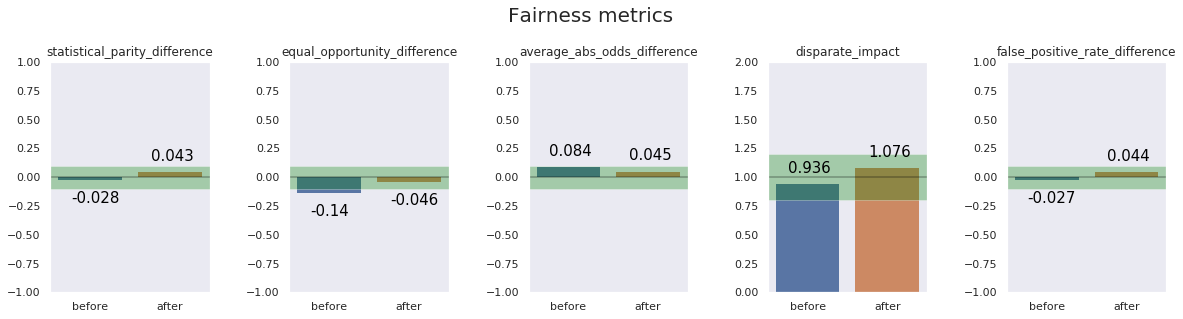

In [64]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_lr, original_test_dataset, dataset_ROC_test_pred_lr.labels)

### Bias metrics

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the before attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the after attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,false_positive_rate_difference
objective,0.000000,0.000000,0.000000,1.000000,0.000000
before,-0.019760,-0.119203,0.068822,0.960503,-0.018441
after,0.029388,-0.102536,0.066838,1.036407,0.031140


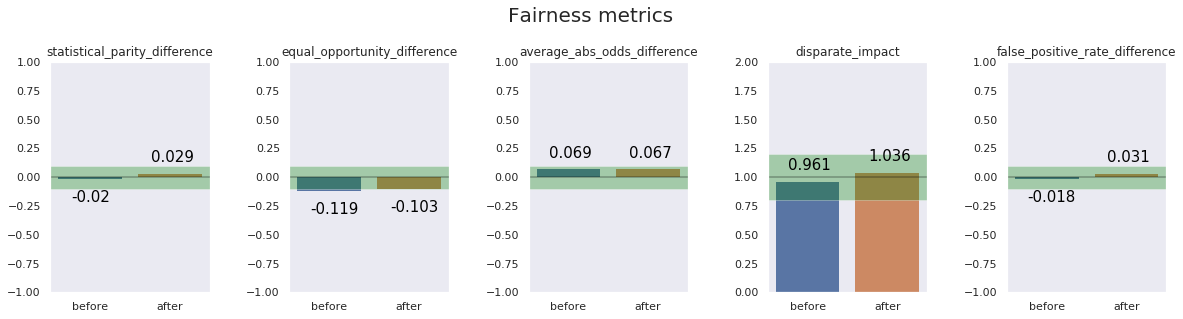

In [65]:
display(Markdown('### Bias metrics'))
fair_reweighing = get_fair_metrics_and_plot(original_test_dataset, y_pred_svc, original_test_dataset, dataset_ROC_test_pred_svc.labels)